## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-12 00:46:18--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.96.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.96.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  16.7MB/s    in 21s     

2019-10-12 00:46:40 (15.5 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        # convolutional layer (sees 224x224x1 image tensor)
        self.conv1 = nn.Conv2d(1, 3, 5, padding=2)
        # convolutional layer (sees 112x112x3 tensor)
        self.conv2 = nn.Conv2d(3, 9, 5, padding=2)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (9 * 56 * 56 -> 500)
        self.fc1 = nn.Linear(9 * 56 * 56, 300)
        # linear layer (300-> 136)
        self.fc2 = nn.Linear(300, 136)
        # dropout layer (p=0.20)
        self.dropout = nn.Dropout(0.20)
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
        
         # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten image input
        x = x.view(-1, 9 * 56 * 56)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        

        # a modified x, having gone through all the layers of your model, should be returned
        return x


## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you


net = Net()
print(net)
net.cuda()

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [0]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2


class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

    
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
#from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
#from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),RandomCrop(224),Normalize(),ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/content/drive/My Drive/P1_Facial_Keypoints-master/data/training_frames_keypoints.csv',
                                             root_dir='/content/drive/My Drive/P1_Facial_Keypoints-master/data/training',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [0]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/content/drive/My Drive/P1_Facial_Keypoints-master/data/test_frames_keypoints.csv',
                                             root_dir='/content/drive/My Drive/P1_Facial_Keypoints-master/data/test',
                                             transform=data_transform)



In [0]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].cuda()
        image1= sample['image']
        key_pts = sample['keypoints'].type(torch.FloatTensor).cuda()
        key_pts1 = sample['keypoints'].type(torch.FloatTensor)
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).cuda()

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
           return image1, output_pts, key_pts1

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [12]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

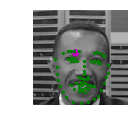

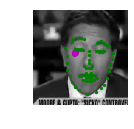

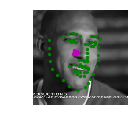

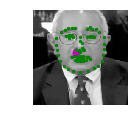

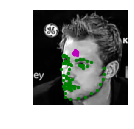

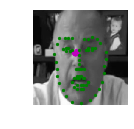

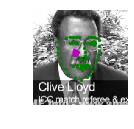

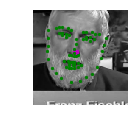

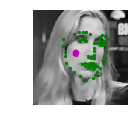

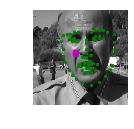

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data.cpu()   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim



criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).cuda()
            images = images.type(torch.FloatTensor).cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [23]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 1, Batch: 10, Avg. Loss: 0.0017308015301823617
Epoch: 1, Batch: 20, Avg. Loss: 0.0015065937638282776
Epoch: 1, Batch: 30, Avg. Loss: 0.0020471733808517458
Epoch: 1, Batch: 40, Avg. Loss: 0.0010997366197407245
Epoch: 1, Batch: 50, Avg. Loss: 0.0017465680241584777
Epoch: 1, Batch: 60, Avg. Loss: 0.00144959869235754
Epoch: 1, Batch: 70, Avg. Loss: 0.0013359481617808342
Epoch: 1, Batch: 80, Avg. Loss: 0.0020270988941192628
Epoch: 1, Batch: 90, Avg. Loss: 0.0018014531284570694
Epoch: 1, Batch: 100, Avg. Loss: 0.001387465998530388
Epoch: 1, Batch: 110, Avg. Loss: 0.0016859813928604126
Epoch: 1, Batch: 120, Avg. Loss: 0.0012351114004850387
Epoch: 1, Batch: 130, Avg. Loss: 0.0015938940048217773
Epoch: 1, Batch: 140, Avg. Loss: 0.00145790583640337
Epoch: 1, Batch: 150, Avg. Loss: 0.0015994064211845398
Epoch: 1, Batch: 160, Avg. Loss: 0.0014447951689362526
Epoch: 1, Batch: 170, Avg. Loss: 0.0018038657456636428
Epoch: 1, Batch: 180, Avg. Loss: 0.0017193118408322333
Epoch: 1, Batch: 190, Av

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 2, Batch: 10, Avg. Loss: 0.0016495406478643417
Epoch: 2, Batch: 20, Avg. Loss: 0.001187399696558714
Epoch: 2, Batch: 30, Avg. Loss: 0.0014606204107403755
Epoch: 2, Batch: 40, Avg. Loss: 0.0015929665118455886
Epoch: 2, Batch: 50, Avg. Loss: 0.001948544878512621
Epoch: 2, Batch: 60, Avg. Loss: 0.0016928695365786553
Epoch: 2, Batch: 70, Avg. Loss: 0.001294888138771057
Epoch: 2, Batch: 80, Avg. Loss: 0.0014352052584290505
Epoch: 2, Batch: 90, Avg. Loss: 0.0018798286765813828
Epoch: 2, Batch: 100, Avg. Loss: 0.0018785439059138297
Epoch: 2, Batch: 110, Avg. Loss: 0.0016462851539254188
Epoch: 2, Batch: 120, Avg. Loss: 0.0017209346368908883
Epoch: 2, Batch: 130, Avg. Loss: 0.0014739900454878807
Epoch: 2, Batch: 140, Avg. Loss: 0.0013651987463235856
Epoch: 2, Batch: 150, Avg. Loss: 0.0015535514876246453
Epoch: 2, Batch: 160, Avg. Loss: 0.0015887272208929062
Epoch: 2, Batch: 170, Avg. Loss: 0.0017458182498812675
Epoch: 2, Batch: 180, Avg. Loss: 0.0012029567882418633
Epoch: 2, Batch: 190, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 3, Batch: 10, Avg. Loss: 0.0012293423637747764
Epoch: 3, Batch: 20, Avg. Loss: 0.0015428588315844537
Epoch: 3, Batch: 30, Avg. Loss: 0.0017584163099527358
Epoch: 3, Batch: 40, Avg. Loss: 0.0018266576901078224
Epoch: 3, Batch: 50, Avg. Loss: 0.0017306729257106782
Epoch: 3, Batch: 60, Avg. Loss: 0.0014071092531085015
Epoch: 3, Batch: 70, Avg. Loss: 0.001079514443874359
Epoch: 3, Batch: 80, Avg. Loss: 0.001877351075410843
Epoch: 3, Batch: 90, Avg. Loss: 0.0014354661852121354
Epoch: 3, Batch: 100, Avg. Loss: 0.001760844737291336
Epoch: 3, Batch: 110, Avg. Loss: 0.0014072183072566986
Epoch: 3, Batch: 120, Avg. Loss: 0.001517564482986927
Epoch: 3, Batch: 130, Avg. Loss: 0.0016039212122559547
Epoch: 3, Batch: 140, Avg. Loss: 0.0021886944472789766
Epoch: 3, Batch: 150, Avg. Loss: 0.0015756057351827622
Epoch: 3, Batch: 160, Avg. Loss: 0.001467658407986164
Epoch: 3, Batch: 170, Avg. Loss: 0.00165739406645298
Epoch: 3, Batch: 180, Avg. Loss: 0.0015799413919448853
Epoch: 3, Batch: 190, Avg.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 4, Batch: 10, Avg. Loss: 0.0016257281601428986
Epoch: 4, Batch: 20, Avg. Loss: 0.0014322628304362297
Epoch: 4, Batch: 30, Avg. Loss: 0.00161636982858181
Epoch: 4, Batch: 40, Avg. Loss: 0.0015986529663205146
Epoch: 4, Batch: 50, Avg. Loss: 0.0018385528177022935
Epoch: 4, Batch: 60, Avg. Loss: 0.0013421868607401848
Epoch: 4, Batch: 70, Avg. Loss: 0.0014699724242091179
Epoch: 4, Batch: 80, Avg. Loss: 0.001984090402722359
Epoch: 4, Batch: 90, Avg. Loss: 0.001765545405447483
Epoch: 4, Batch: 100, Avg. Loss: 0.00157709988206625
Epoch: 4, Batch: 110, Avg. Loss: 0.001666400022804737
Epoch: 4, Batch: 120, Avg. Loss: 0.0013188114613294601
Epoch: 4, Batch: 130, Avg. Loss: 0.0014571768268942832
Epoch: 4, Batch: 140, Avg. Loss: 0.0013322107791900635
Epoch: 4, Batch: 150, Avg. Loss: 0.0022782231345772745
Epoch: 4, Batch: 160, Avg. Loss: 0.001694834440946579
Epoch: 4, Batch: 170, Avg. Loss: 0.0018003726676106453
Epoch: 4, Batch: 180, Avg. Loss: 0.0018912862166762352
Epoch: 4, Batch: 190, Avg. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 5, Batch: 10, Avg. Loss: 0.0017854303866624832
Epoch: 5, Batch: 20, Avg. Loss: 0.0015268552526831627
Epoch: 5, Batch: 30, Avg. Loss: 0.0012354603484272958
Epoch: 5, Batch: 40, Avg. Loss: 0.0012898537144064902
Epoch: 5, Batch: 50, Avg. Loss: 0.0017425719574093819
Epoch: 5, Batch: 60, Avg. Loss: 0.0014263183474540711
Epoch: 5, Batch: 70, Avg. Loss: 0.0013069643080234528
Epoch: 5, Batch: 80, Avg. Loss: 0.0017714965119957923
Epoch: 5, Batch: 90, Avg. Loss: 0.0018639060631394386
Epoch: 5, Batch: 100, Avg. Loss: 0.0012299188785254956
Epoch: 5, Batch: 110, Avg. Loss: 0.0017077510878443717
Epoch: 5, Batch: 120, Avg. Loss: 0.0017059322595596314
Epoch: 5, Batch: 130, Avg. Loss: 0.00153275203704834
Epoch: 5, Batch: 140, Avg. Loss: 0.001601829320192337
Epoch: 5, Batch: 150, Avg. Loss: 0.0015858505293726921
Epoch: 5, Batch: 160, Avg. Loss: 0.0018644217625260354
Epoch: 5, Batch: 170, Avg. Loss: 0.0014408503919839859
Epoch: 5, Batch: 180, Avg. Loss: 0.0013421322107315063
Epoch: 5, Batch: 190, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 6, Batch: 10, Avg. Loss: 0.001348155491054058
Epoch: 6, Batch: 20, Avg. Loss: 0.001680609792470932
Epoch: 6, Batch: 30, Avg. Loss: 0.0014350253418087958
Epoch: 6, Batch: 40, Avg. Loss: 0.0012648432701826097
Epoch: 6, Batch: 50, Avg. Loss: 0.0020144654512405397
Epoch: 6, Batch: 60, Avg. Loss: 0.0012657029926776886
Epoch: 6, Batch: 70, Avg. Loss: 0.0023355964049696924
Epoch: 6, Batch: 80, Avg. Loss: 0.0012892691195011139
Epoch: 6, Batch: 90, Avg. Loss: 0.0015888856798410415
Epoch: 6, Batch: 100, Avg. Loss: 0.0014806673526763915
Epoch: 6, Batch: 110, Avg. Loss: 0.00396107193082571
Epoch: 6, Batch: 120, Avg. Loss: 0.0012921247854828836
Epoch: 6, Batch: 130, Avg. Loss: 0.0015002971887588502
Epoch: 6, Batch: 140, Avg. Loss: 0.0021964562088251116
Epoch: 6, Batch: 150, Avg. Loss: 0.0014598464891314507
Epoch: 6, Batch: 160, Avg. Loss: 0.0013783514872193336
Epoch: 6, Batch: 170, Avg. Loss: 0.002031515635550022
Epoch: 6, Batch: 180, Avg. Loss: 0.0017406297251582146
Epoch: 6, Batch: 190, Av

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 7, Batch: 10, Avg. Loss: 0.002335539385676384
Epoch: 7, Batch: 20, Avg. Loss: 0.0015346978604793549
Epoch: 7, Batch: 30, Avg. Loss: 0.0017296886071562767
Epoch: 7, Batch: 40, Avg. Loss: 0.0013613278344273567
Epoch: 7, Batch: 50, Avg. Loss: 0.001814259335398674
Epoch: 7, Batch: 60, Avg. Loss: 0.0015212090909481049
Epoch: 7, Batch: 70, Avg. Loss: 0.0013062449693679809
Epoch: 7, Batch: 80, Avg. Loss: 0.0012549999803304673
Epoch: 7, Batch: 90, Avg. Loss: 0.001769941009581089
Epoch: 7, Batch: 100, Avg. Loss: 0.0014263187348842622
Epoch: 7, Batch: 110, Avg. Loss: 0.0013018004223704339
Epoch: 7, Batch: 120, Avg. Loss: 0.0014885071665048598
Epoch: 7, Batch: 130, Avg. Loss: 0.0014424107298254966
Epoch: 7, Batch: 140, Avg. Loss: 0.0014615307971835136
Epoch: 7, Batch: 150, Avg. Loss: 0.0015049406066536904
Epoch: 7, Batch: 160, Avg. Loss: 0.0013098239377140998
Epoch: 7, Batch: 170, Avg. Loss: 0.0014996654316782952
Epoch: 7, Batch: 180, Avg. Loss: 0.001175854004919529
Epoch: 7, Batch: 190, A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 8, Batch: 10, Avg. Loss: 0.0013244014829397201
Epoch: 8, Batch: 20, Avg. Loss: 0.0016853075549006463
Epoch: 8, Batch: 30, Avg. Loss: 0.0015883908569812775
Epoch: 8, Batch: 40, Avg. Loss: 0.002021604597568512
Epoch: 8, Batch: 50, Avg. Loss: 0.0018993459567427636
Epoch: 8, Batch: 60, Avg. Loss: 0.0019466968700289726
Epoch: 8, Batch: 70, Avg. Loss: 0.001564119666814804
Epoch: 8, Batch: 80, Avg. Loss: 0.0016693762540817261
Epoch: 8, Batch: 90, Avg. Loss: 0.0018228339552879334
Epoch: 8, Batch: 100, Avg. Loss: 0.0018821451291441917
Epoch: 8, Batch: 110, Avg. Loss: 0.0013972960114479066
Epoch: 8, Batch: 120, Avg. Loss: 0.0016125752478837966
Epoch: 8, Batch: 130, Avg. Loss: 0.0013127874433994293
Epoch: 8, Batch: 140, Avg. Loss: 0.0011838852502405644
Epoch: 8, Batch: 150, Avg. Loss: 0.0014070715084671974
Epoch: 8, Batch: 160, Avg. Loss: 0.0017975631207227706
Epoch: 8, Batch: 170, Avg. Loss: 0.001310864210128784
Epoch: 8, Batch: 180, Avg. Loss: 0.0014090989902615547
Epoch: 8, Batch: 190, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 9, Batch: 10, Avg. Loss: 0.001429766058921814
Epoch: 9, Batch: 20, Avg. Loss: 0.0015921031050384045
Epoch: 9, Batch: 30, Avg. Loss: 0.001399552822113037
Epoch: 9, Batch: 40, Avg. Loss: 0.001413902185857296
Epoch: 9, Batch: 50, Avg. Loss: 0.0022109186053276063
Epoch: 9, Batch: 60, Avg. Loss: 0.0016213170364499092
Epoch: 9, Batch: 70, Avg. Loss: 0.0013390682637691499
Epoch: 9, Batch: 80, Avg. Loss: 0.002252287246286869
Epoch: 9, Batch: 90, Avg. Loss: 0.0013438820764422417
Epoch: 9, Batch: 100, Avg. Loss: 0.0020532472059130668
Epoch: 9, Batch: 110, Avg. Loss: 0.001523266650736332
Epoch: 9, Batch: 120, Avg. Loss: 0.0013782401606440545
Epoch: 9, Batch: 130, Avg. Loss: 0.0015117038562893867
Epoch: 9, Batch: 140, Avg. Loss: 0.0013551919907331467
Epoch: 9, Batch: 150, Avg. Loss: 0.0018006400279700755
Epoch: 9, Batch: 160, Avg. Loss: 0.001351699985563755
Epoch: 9, Batch: 170, Avg. Loss: 0.0013111758008599282
Epoch: 9, Batch: 180, Avg. Loss: 0.0014219157993793487
Epoch: 9, Batch: 190, Avg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 10, Batch: 10, Avg. Loss: 0.0013128129169344901
Epoch: 10, Batch: 20, Avg. Loss: 0.0015078475400805474
Epoch: 10, Batch: 30, Avg. Loss: 0.0028808363378047945
Epoch: 10, Batch: 40, Avg. Loss: 0.0017080614268779755
Epoch: 10, Batch: 50, Avg. Loss: 0.0016687978208065034
Epoch: 10, Batch: 60, Avg. Loss: 0.0013416663855314254
Epoch: 10, Batch: 70, Avg. Loss: 0.0016206063255667686
Epoch: 10, Batch: 80, Avg. Loss: 0.0013904637321829796
Epoch: 10, Batch: 90, Avg. Loss: 0.0016668348237872123
Epoch: 10, Batch: 100, Avg. Loss: 0.0015168876126408577
Epoch: 10, Batch: 110, Avg. Loss: 0.0015314306393265724
Epoch: 10, Batch: 120, Avg. Loss: 0.0014666365906596183
Epoch: 10, Batch: 130, Avg. Loss: 0.0015171098783612251
Epoch: 10, Batch: 140, Avg. Loss: 0.0011472970508038997
Epoch: 10, Batch: 150, Avg. Loss: 0.0013639252930879593
Epoch: 10, Batch: 160, Avg. Loss: 0.0012356600016355515
Epoch: 10, Batch: 170, Avg. Loss: 0.0013386879935860633
Epoch: 10, Batch: 180, Avg. Loss: 0.001599188543856144
Ep

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 11, Batch: 10, Avg. Loss: 0.001624479666352272
Epoch: 11, Batch: 20, Avg. Loss: 0.0015252485349774361
Epoch: 11, Batch: 30, Avg. Loss: 0.001421426422894001
Epoch: 11, Batch: 40, Avg. Loss: 0.0012887356355786323
Epoch: 11, Batch: 50, Avg. Loss: 0.002012947976589203
Epoch: 11, Batch: 60, Avg. Loss: 0.0020840951427817346
Epoch: 11, Batch: 70, Avg. Loss: 0.0017657039389014245
Epoch: 11, Batch: 80, Avg. Loss: 0.0014780146256089212
Epoch: 11, Batch: 90, Avg. Loss: 0.001343331314623356
Epoch: 11, Batch: 100, Avg. Loss: 0.0014280438348650932
Epoch: 11, Batch: 110, Avg. Loss: 0.0013489185348153113
Epoch: 11, Batch: 120, Avg. Loss: 0.0013613154590129853
Epoch: 11, Batch: 130, Avg. Loss: 0.0016908507123589516
Epoch: 11, Batch: 140, Avg. Loss: 0.0014370570108294487
Epoch: 11, Batch: 150, Avg. Loss: 0.0011830992847681045
Epoch: 11, Batch: 160, Avg. Loss: 0.0015030628740787507
Epoch: 11, Batch: 170, Avg. Loss: 0.001459561787545681
Epoch: 11, Batch: 180, Avg. Loss: 0.001638480931520462
Epoch: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 12, Batch: 10, Avg. Loss: 0.001397863231599331
Epoch: 12, Batch: 20, Avg. Loss: 0.0012823957726359368
Epoch: 12, Batch: 30, Avg. Loss: 0.0014133637845516204
Epoch: 12, Batch: 40, Avg. Loss: 0.0013804075643420218
Epoch: 12, Batch: 50, Avg. Loss: 0.0011872363090515137
Epoch: 12, Batch: 60, Avg. Loss: 0.002192025728523731
Epoch: 12, Batch: 70, Avg. Loss: 0.001485149435698986
Epoch: 12, Batch: 80, Avg. Loss: 0.0010939342528581619
Epoch: 12, Batch: 90, Avg. Loss: 0.0014000011906027793
Epoch: 12, Batch: 100, Avg. Loss: 0.0013124101758003235
Epoch: 12, Batch: 110, Avg. Loss: 0.0017108442336320876
Epoch: 12, Batch: 120, Avg. Loss: 0.0014784064814448356
Epoch: 12, Batch: 130, Avg. Loss: 0.001893482431769371
Epoch: 12, Batch: 140, Avg. Loss: 0.0014109792187809943
Epoch: 12, Batch: 150, Avg. Loss: 0.0015229959040880202
Epoch: 12, Batch: 160, Avg. Loss: 0.001977410025894642
Epoch: 12, Batch: 170, Avg. Loss: 0.0017976943850517273
Epoch: 12, Batch: 180, Avg. Loss: 0.0014307555258274078
Epoch:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 13, Batch: 10, Avg. Loss: 0.002027123585343361
Epoch: 13, Batch: 20, Avg. Loss: 0.0013258815184235572
Epoch: 13, Batch: 30, Avg. Loss: 0.001623762510716915
Epoch: 13, Batch: 40, Avg. Loss: 0.0017844535112380982
Epoch: 13, Batch: 50, Avg. Loss: 0.0013403660506010055
Epoch: 13, Batch: 60, Avg. Loss: 0.0015337435379624367
Epoch: 13, Batch: 70, Avg. Loss: 0.0014284057319164276
Epoch: 13, Batch: 80, Avg. Loss: 0.0014084093049168587
Epoch: 13, Batch: 90, Avg. Loss: 0.0013958927243947982
Epoch: 13, Batch: 100, Avg. Loss: 0.0014294788800179958
Epoch: 13, Batch: 110, Avg. Loss: 0.0015195315778255463
Epoch: 13, Batch: 120, Avg. Loss: 0.0011965226531028747
Epoch: 13, Batch: 130, Avg. Loss: 0.0013315389156341553
Epoch: 13, Batch: 140, Avg. Loss: 0.0011999613717198372
Epoch: 13, Batch: 150, Avg. Loss: 0.0013644608706235885
Epoch: 13, Batch: 160, Avg. Loss: 0.0015080334171652793
Epoch: 13, Batch: 170, Avg. Loss: 0.001619982399046421
Epoch: 13, Batch: 180, Avg. Loss: 0.0012472406178712845
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 14, Batch: 10, Avg. Loss: 0.0013777461722493172
Epoch: 14, Batch: 20, Avg. Loss: 0.001215352512896061
Epoch: 14, Batch: 30, Avg. Loss: 0.0013660875633358955
Epoch: 14, Batch: 40, Avg. Loss: 0.0013051254227757455
Epoch: 14, Batch: 50, Avg. Loss: 0.0017395773008465768
Epoch: 14, Batch: 60, Avg. Loss: 0.0016322064325213432
Epoch: 14, Batch: 70, Avg. Loss: 0.0014481900222599506
Epoch: 14, Batch: 80, Avg. Loss: 0.0014256702810525894
Epoch: 14, Batch: 90, Avg. Loss: 0.0014548562094569206
Epoch: 14, Batch: 100, Avg. Loss: 0.0014329036921262742
Epoch: 14, Batch: 110, Avg. Loss: 0.001395003378391266
Epoch: 14, Batch: 120, Avg. Loss: 0.0015709367692470552
Epoch: 14, Batch: 130, Avg. Loss: 0.0014392806254327297
Epoch: 14, Batch: 140, Avg. Loss: 0.0011363802030682564
Epoch: 14, Batch: 150, Avg. Loss: 0.0015371113196015359
Epoch: 14, Batch: 160, Avg. Loss: 0.0011878097653388977
Epoch: 14, Batch: 170, Avg. Loss: 0.001466401681303978
Epoch: 14, Batch: 180, Avg. Loss: 0.0017719733119010924
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 15, Batch: 10, Avg. Loss: 0.001296373575925827
Epoch: 15, Batch: 20, Avg. Loss: 0.001462969034910202
Epoch: 15, Batch: 30, Avg. Loss: 0.0015319040417671203
Epoch: 15, Batch: 40, Avg. Loss: 0.0017477021887898445
Epoch: 15, Batch: 50, Avg. Loss: 0.0014221755191683768
Epoch: 15, Batch: 60, Avg. Loss: 0.001287001021206379
Epoch: 15, Batch: 70, Avg. Loss: 0.0016574960947036742
Epoch: 15, Batch: 80, Avg. Loss: 0.0014249995946884156
Epoch: 15, Batch: 90, Avg. Loss: 0.0013046282157301902
Epoch: 15, Batch: 100, Avg. Loss: 0.0013564153090119362
Epoch: 15, Batch: 110, Avg. Loss: 0.0020196631252765657
Epoch: 15, Batch: 120, Avg. Loss: 0.0014504322484135627
Epoch: 15, Batch: 130, Avg. Loss: 0.001380028411746025
Epoch: 15, Batch: 140, Avg. Loss: 0.0013330504223704339
Epoch: 15, Batch: 150, Avg. Loss: 0.0019042222499847411
Epoch: 15, Batch: 160, Avg. Loss: 0.0019214190468192101
Epoch: 15, Batch: 170, Avg. Loss: 0.0013651324957609176
Epoch: 15, Batch: 180, Avg. Loss: 0.001606055960059166
Epoch:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 16, Batch: 10, Avg. Loss: 0.0015834178775548935
Epoch: 16, Batch: 20, Avg. Loss: 0.001212205894291401
Epoch: 16, Batch: 30, Avg. Loss: 0.0018648515418171882
Epoch: 16, Batch: 40, Avg. Loss: 0.0035522542670369146
Epoch: 16, Batch: 50, Avg. Loss: 0.0013848823457956313
Epoch: 16, Batch: 60, Avg. Loss: 0.0016205982863903045
Epoch: 16, Batch: 70, Avg. Loss: 0.0012996180802583694
Epoch: 16, Batch: 80, Avg. Loss: 0.0013279893547296525
Epoch: 16, Batch: 90, Avg. Loss: 0.0016137002632021903
Epoch: 16, Batch: 100, Avg. Loss: 0.0018672979846596717
Epoch: 16, Batch: 110, Avg. Loss: 0.0013154802545905114
Epoch: 16, Batch: 120, Avg. Loss: 0.0013338738866150379
Epoch: 16, Batch: 130, Avg. Loss: 0.0011433942466974258
Epoch: 16, Batch: 140, Avg. Loss: 0.0011844201236963273
Epoch: 16, Batch: 150, Avg. Loss: 0.0013513348773121834
Epoch: 16, Batch: 160, Avg. Loss: 0.0012792041450738908
Epoch: 16, Batch: 170, Avg. Loss: 0.001326908178627491
Epoch: 16, Batch: 180, Avg. Loss: 0.0016980027630925179
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 17, Batch: 10, Avg. Loss: 0.0011612517908215522
Epoch: 17, Batch: 20, Avg. Loss: 0.001559741012752056
Epoch: 17, Batch: 30, Avg. Loss: 0.0013241909816861153
Epoch: 17, Batch: 40, Avg. Loss: 0.0017354488223791122
Epoch: 17, Batch: 50, Avg. Loss: 0.0019148737862706184
Epoch: 17, Batch: 60, Avg. Loss: 0.0018584314063191413
Epoch: 17, Batch: 70, Avg. Loss: 0.0013196349591016769
Epoch: 17, Batch: 80, Avg. Loss: 0.0014850128516554833
Epoch: 17, Batch: 90, Avg. Loss: 0.0015877686515450478
Epoch: 17, Batch: 100, Avg. Loss: 0.001210540931671858
Epoch: 17, Batch: 110, Avg. Loss: 0.0017547550424933432
Epoch: 17, Batch: 120, Avg. Loss: 0.0014401623830199242
Epoch: 17, Batch: 130, Avg. Loss: 0.0014012842550873757
Epoch: 17, Batch: 140, Avg. Loss: 0.0010677479207515717
Epoch: 17, Batch: 150, Avg. Loss: 0.001494517371058464
Epoch: 17, Batch: 160, Avg. Loss: 0.0017396439686417579
Epoch: 17, Batch: 170, Avg. Loss: 0.0015374000817537307
Epoch: 17, Batch: 180, Avg. Loss: 0.0019381814897060394
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 18, Batch: 10, Avg. Loss: 0.0012434830479323864
Epoch: 18, Batch: 20, Avg. Loss: 0.001274802528321743
Epoch: 18, Batch: 30, Avg. Loss: 0.0015149775072932244
Epoch: 18, Batch: 40, Avg. Loss: 0.001452103279531002
Epoch: 18, Batch: 50, Avg. Loss: 0.001415270559489727
Epoch: 18, Batch: 60, Avg. Loss: 0.001523095816373825
Epoch: 18, Batch: 70, Avg. Loss: 0.0012452669590711594
Epoch: 18, Batch: 80, Avg. Loss: 0.0013616321608424186
Epoch: 18, Batch: 90, Avg. Loss: 0.0013742449507117272
Epoch: 18, Batch: 100, Avg. Loss: 0.0014813051596283913
Epoch: 18, Batch: 110, Avg. Loss: 0.001796773746609688
Epoch: 18, Batch: 120, Avg. Loss: 0.0013877403438091278
Epoch: 18, Batch: 130, Avg. Loss: 0.0013155509531497956
Epoch: 18, Batch: 140, Avg. Loss: 0.00130789764970541
Epoch: 18, Batch: 150, Avg. Loss: 0.001278453528881073
Epoch: 18, Batch: 160, Avg. Loss: 0.0015341998115181923
Epoch: 18, Batch: 170, Avg. Loss: 0.001224584247916937
Epoch: 18, Batch: 180, Avg. Loss: 0.0014553746581077575
Epoch: 18,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 19, Batch: 10, Avg. Loss: 0.0012665133662521839
Epoch: 19, Batch: 20, Avg. Loss: 0.0015287660509347915
Epoch: 19, Batch: 30, Avg. Loss: 0.0014208365306258202
Epoch: 19, Batch: 40, Avg. Loss: 0.0016994947493076324
Epoch: 19, Batch: 50, Avg. Loss: 0.001692169524729252
Epoch: 19, Batch: 60, Avg. Loss: 0.0013070388287305832
Epoch: 19, Batch: 70, Avg. Loss: 0.0013307307958602905
Epoch: 19, Batch: 80, Avg. Loss: 0.0016399652510881424
Epoch: 19, Batch: 90, Avg. Loss: 0.002285011097788811
Epoch: 19, Batch: 100, Avg. Loss: 0.0014228593781590462
Epoch: 19, Batch: 110, Avg. Loss: 0.0013607279732823373
Epoch: 19, Batch: 120, Avg. Loss: 0.0013923076018691064
Epoch: 19, Batch: 130, Avg. Loss: 0.0016384160220623016
Epoch: 19, Batch: 140, Avg. Loss: 0.0014385528042912482
Epoch: 19, Batch: 150, Avg. Loss: 0.0017411393225193023
Epoch: 19, Batch: 160, Avg. Loss: 0.0016026483476161957
Epoch: 19, Batch: 170, Avg. Loss: 0.0015880672931671144
Epoch: 19, Batch: 180, Avg. Loss: 0.0014886232763528823
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 20, Batch: 10, Avg. Loss: 0.0014768122993409633
Epoch: 20, Batch: 20, Avg. Loss: 0.001675548292696476
Epoch: 20, Batch: 30, Avg. Loss: 0.001580608293414116
Epoch: 20, Batch: 40, Avg. Loss: 0.0013513884022831916
Epoch: 20, Batch: 50, Avg. Loss: 0.0016288615986704827
Epoch: 20, Batch: 60, Avg. Loss: 0.0013581970557570457
Epoch: 20, Batch: 70, Avg. Loss: 0.0013394313305616378
Epoch: 20, Batch: 80, Avg. Loss: 0.0012245070412755014
Epoch: 20, Batch: 90, Avg. Loss: 0.0015273204743862152
Epoch: 20, Batch: 100, Avg. Loss: 0.0012730423286557197
Epoch: 20, Batch: 110, Avg. Loss: 0.0014149262756109238
Epoch: 20, Batch: 120, Avg. Loss: 0.0016437405422329904
Epoch: 20, Batch: 130, Avg. Loss: 0.0011865274012088775
Epoch: 20, Batch: 140, Avg. Loss: 0.0011125815510749817
Epoch: 20, Batch: 150, Avg. Loss: 0.0018368272110819816
Epoch: 20, Batch: 160, Avg. Loss: 0.0012605080977082252
Epoch: 20, Batch: 170, Avg. Loss: 0.0014616420567035676
Epoch: 20, Batch: 180, Avg. Loss: 0.0014063190072774888
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 21, Batch: 10, Avg. Loss: 0.0012636006623506545
Epoch: 21, Batch: 20, Avg. Loss: 0.0013249631747603416
Epoch: 21, Batch: 30, Avg. Loss: 0.001238447330892086
Epoch: 21, Batch: 40, Avg. Loss: 0.0013539002239704133
Epoch: 21, Batch: 50, Avg. Loss: 0.0013054960891604424
Epoch: 21, Batch: 60, Avg. Loss: 0.0014027129858732224
Epoch: 21, Batch: 70, Avg. Loss: 0.001289090596139431
Epoch: 21, Batch: 80, Avg. Loss: 0.0015799525752663612
Epoch: 21, Batch: 90, Avg. Loss: 0.0014235903844237328
Epoch: 21, Batch: 100, Avg. Loss: 0.0012357555478811264
Epoch: 21, Batch: 110, Avg. Loss: 0.0014861980825662613
Epoch: 21, Batch: 120, Avg. Loss: 0.0013904611989855767
Epoch: 21, Batch: 130, Avg. Loss: 0.0010803620293736457
Epoch: 21, Batch: 140, Avg. Loss: 0.0017452441081404685
Epoch: 21, Batch: 150, Avg. Loss: 0.0013582246005535126
Epoch: 21, Batch: 160, Avg. Loss: 0.0015849860981106759
Epoch: 21, Batch: 170, Avg. Loss: 0.0015964343547821044
Epoch: 21, Batch: 180, Avg. Loss: 0.001387005053460598
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 22, Batch: 10, Avg. Loss: 0.0011680511757731437
Epoch: 22, Batch: 20, Avg. Loss: 0.0012010052055120468
Epoch: 22, Batch: 30, Avg. Loss: 0.0013613474071025849
Epoch: 22, Batch: 40, Avg. Loss: 0.0012748951688408851
Epoch: 22, Batch: 50, Avg. Loss: 0.0017055928483605384
Epoch: 22, Batch: 60, Avg. Loss: 0.0011379322186112404
Epoch: 22, Batch: 70, Avg. Loss: 0.0015168845877051355
Epoch: 22, Batch: 80, Avg. Loss: 0.0016423562467098236
Epoch: 22, Batch: 90, Avg. Loss: 0.0019952442720532417
Epoch: 22, Batch: 100, Avg. Loss: 0.0016036236733198166
Epoch: 22, Batch: 110, Avg. Loss: 0.0012426564805209637
Epoch: 22, Batch: 120, Avg. Loss: 0.0013600334897637368
Epoch: 22, Batch: 130, Avg. Loss: 0.0013330375254154206
Epoch: 22, Batch: 140, Avg. Loss: 0.0010815193653106688
Epoch: 22, Batch: 150, Avg. Loss: 0.0013835418447852134
Epoch: 22, Batch: 160, Avg. Loss: 0.001820911280810833
Epoch: 22, Batch: 170, Avg. Loss: 0.0015974397212266923
Epoch: 22, Batch: 180, Avg. Loss: 0.0015905046239495276
Ep

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 23, Batch: 10, Avg. Loss: 0.001119956411421299
Epoch: 23, Batch: 20, Avg. Loss: 0.0016383663043379785
Epoch: 23, Batch: 30, Avg. Loss: 0.001663535438477993
Epoch: 23, Batch: 40, Avg. Loss: 0.0013810345605015754
Epoch: 23, Batch: 50, Avg. Loss: 0.0014356734678149224
Epoch: 23, Batch: 60, Avg. Loss: 0.001997854918241501
Epoch: 23, Batch: 70, Avg. Loss: 0.00162882399559021
Epoch: 23, Batch: 80, Avg. Loss: 0.0014420638307929038
Epoch: 23, Batch: 90, Avg. Loss: 0.001479719027876854
Epoch: 23, Batch: 100, Avg. Loss: 0.001372055560350418
Epoch: 23, Batch: 110, Avg. Loss: 0.0018039760403335094
Epoch: 23, Batch: 120, Avg. Loss: 0.001240288533270359
Epoch: 23, Batch: 130, Avg. Loss: 0.0012697148323059081
Epoch: 23, Batch: 140, Avg. Loss: 0.0016256475821137429
Epoch: 23, Batch: 150, Avg. Loss: 0.00119710947945714
Epoch: 23, Batch: 160, Avg. Loss: 0.0013745728656649589
Epoch: 23, Batch: 170, Avg. Loss: 0.0012268816828727722
Epoch: 23, Batch: 180, Avg. Loss: 0.0018684324845671654
Epoch: 23, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 24, Batch: 10, Avg. Loss: 0.0013241967856884003
Epoch: 24, Batch: 20, Avg. Loss: 0.001122178580611944
Epoch: 24, Batch: 30, Avg. Loss: 0.001300434947013855
Epoch: 24, Batch: 40, Avg. Loss: 0.0017426682189106942
Epoch: 24, Batch: 50, Avg. Loss: 0.0021905738934874536
Epoch: 24, Batch: 60, Avg. Loss: 0.0016614915654063224
Epoch: 24, Batch: 70, Avg. Loss: 0.0016179406195878984
Epoch: 24, Batch: 80, Avg. Loss: 0.001222588650882244
Epoch: 24, Batch: 90, Avg. Loss: 0.0016315536201000215
Epoch: 24, Batch: 100, Avg. Loss: 0.001561123639345169
Epoch: 24, Batch: 110, Avg. Loss: 0.0014304135516285895
Epoch: 24, Batch: 120, Avg. Loss: 0.0013112147822976112
Epoch: 24, Batch: 130, Avg. Loss: 0.0013396366909146308
Epoch: 24, Batch: 140, Avg. Loss: 0.0011563310325145722
Epoch: 24, Batch: 150, Avg. Loss: 0.0014623465910553932
Epoch: 24, Batch: 160, Avg. Loss: 0.0014062020257115365
Epoch: 24, Batch: 170, Avg. Loss: 0.00122776560485363
Epoch: 24, Batch: 180, Avg. Loss: 0.0009312885254621505
Epoch: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 25, Batch: 10, Avg. Loss: 0.0009060561358928681
Epoch: 25, Batch: 20, Avg. Loss: 0.0012244389951229096
Epoch: 25, Batch: 30, Avg. Loss: 0.001332108736038208
Epoch: 25, Batch: 40, Avg. Loss: 0.0012699127942323685
Epoch: 25, Batch: 50, Avg. Loss: 0.002235031448304653
Epoch: 25, Batch: 60, Avg. Loss: 0.0011609939485788345
Epoch: 25, Batch: 70, Avg. Loss: 0.0015365994870662689
Epoch: 25, Batch: 80, Avg. Loss: 0.0010419004261493683
Epoch: 25, Batch: 90, Avg. Loss: 0.001668458640575409
Epoch: 25, Batch: 100, Avg. Loss: 0.0012938611283898353
Epoch: 25, Batch: 110, Avg. Loss: 0.0011238629966974258
Epoch: 25, Batch: 120, Avg. Loss: 0.0011833619251847268
Epoch: 25, Batch: 130, Avg. Loss: 0.0014310247898101807
Epoch: 25, Batch: 140, Avg. Loss: 0.0011413708627223968
Epoch: 25, Batch: 150, Avg. Loss: 0.0012961242720484734
Epoch: 25, Batch: 160, Avg. Loss: 0.0018283994495868683
Epoch: 25, Batch: 170, Avg. Loss: 0.0015375865772366524
Epoch: 25, Batch: 180, Avg. Loss: 0.0015688869506120683
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 26, Batch: 10, Avg. Loss: 0.001381819725036621
Epoch: 26, Batch: 20, Avg. Loss: 0.0015049217864871024
Epoch: 26, Batch: 30, Avg. Loss: 0.0013357537388801574
Epoch: 26, Batch: 40, Avg. Loss: 0.001466085061430931
Epoch: 26, Batch: 50, Avg. Loss: 0.0021550087183713914
Epoch: 26, Batch: 60, Avg. Loss: 0.0018721018061041831
Epoch: 26, Batch: 70, Avg. Loss: 0.0012334713339805603
Epoch: 26, Batch: 80, Avg. Loss: 0.0010187429971992969
Epoch: 26, Batch: 90, Avg. Loss: 0.0014989430159330368
Epoch: 26, Batch: 100, Avg. Loss: 0.0018365156129002572
Epoch: 26, Batch: 110, Avg. Loss: 0.0012268486618995666
Epoch: 26, Batch: 120, Avg. Loss: 0.0011804908141493798
Epoch: 26, Batch: 130, Avg. Loss: 0.0014384605959057808
Epoch: 26, Batch: 140, Avg. Loss: 0.001132928416132927
Epoch: 26, Batch: 150, Avg. Loss: 0.0017941154092550279
Epoch: 26, Batch: 160, Avg. Loss: 0.0014366639629006385
Epoch: 26, Batch: 170, Avg. Loss: 0.0014637423902750016
Epoch: 26, Batch: 180, Avg. Loss: 0.0012916060164570808
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 27, Batch: 10, Avg. Loss: 0.0014434080943465232
Epoch: 27, Batch: 20, Avg. Loss: 0.0012547799423336982
Epoch: 27, Batch: 30, Avg. Loss: 0.0014775868579745292
Epoch: 27, Batch: 40, Avg. Loss: 0.0019395162984728812
Epoch: 27, Batch: 50, Avg. Loss: 0.0015247326344251632
Epoch: 27, Batch: 60, Avg. Loss: 0.0018622880280017853
Epoch: 27, Batch: 70, Avg. Loss: 0.0028026105761528013
Epoch: 27, Batch: 80, Avg. Loss: 0.0012852802909910678
Epoch: 27, Batch: 90, Avg. Loss: 0.003031212463974953
Epoch: 27, Batch: 100, Avg. Loss: 0.0012663012444972992
Epoch: 27, Batch: 110, Avg. Loss: 0.001305234484374523
Epoch: 27, Batch: 120, Avg. Loss: 0.001401975430548191
Epoch: 27, Batch: 130, Avg. Loss: 0.0013323252946138382
Epoch: 27, Batch: 140, Avg. Loss: 0.0016614454537630082
Epoch: 27, Batch: 150, Avg. Loss: 0.0015423808842897416
Epoch: 27, Batch: 160, Avg. Loss: 0.00125907938554883
Epoch: 27, Batch: 170, Avg. Loss: 0.001318963296711445
Epoch: 27, Batch: 180, Avg. Loss: 0.0012905680909752846
Epoch: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 28, Batch: 10, Avg. Loss: 0.0014492894634604455
Epoch: 28, Batch: 20, Avg. Loss: 0.001128600500524044
Epoch: 28, Batch: 30, Avg. Loss: 0.0015671154260635375
Epoch: 28, Batch: 40, Avg. Loss: 0.001284284468740225
Epoch: 28, Batch: 50, Avg. Loss: 0.0012820834740996361
Epoch: 28, Batch: 60, Avg. Loss: 0.0016635762453079224
Epoch: 28, Batch: 70, Avg. Loss: 0.0013819914907217026
Epoch: 28, Batch: 80, Avg. Loss: 0.0014194874316453933
Epoch: 28, Batch: 90, Avg. Loss: 0.001422951340675354
Epoch: 28, Batch: 100, Avg. Loss: 0.0016468496471643448
Epoch: 28, Batch: 110, Avg. Loss: 0.001716565988957882
Epoch: 28, Batch: 120, Avg. Loss: 0.0011589231714606285
Epoch: 28, Batch: 130, Avg. Loss: 0.001758186936378479
Epoch: 28, Batch: 140, Avg. Loss: 0.0012316161915659905
Epoch: 28, Batch: 150, Avg. Loss: 0.0010970580838620663
Epoch: 28, Batch: 160, Avg. Loss: 0.001503963939845562
Epoch: 28, Batch: 170, Avg. Loss: 0.001417374063283205
Epoch: 28, Batch: 180, Avg. Loss: 0.0013809404745697975
Epoch: 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 29, Batch: 10, Avg. Loss: 0.001355020895600319
Epoch: 29, Batch: 20, Avg. Loss: 0.0013627825826406479
Epoch: 29, Batch: 30, Avg. Loss: 0.0012864226922392845
Epoch: 29, Batch: 40, Avg. Loss: 0.0014253669269382954
Epoch: 29, Batch: 50, Avg. Loss: 0.0014381454586982728
Epoch: 29, Batch: 60, Avg. Loss: 0.001735506407916546
Epoch: 29, Batch: 70, Avg. Loss: 0.0011745042204856873
Epoch: 29, Batch: 80, Avg. Loss: 0.0010948110222816468
Epoch: 29, Batch: 90, Avg. Loss: 0.001449732504785061
Epoch: 29, Batch: 100, Avg. Loss: 0.001618779495358467
Epoch: 29, Batch: 110, Avg. Loss: 0.0010342453084886073
Epoch: 29, Batch: 120, Avg. Loss: 0.0013660456091165543
Epoch: 29, Batch: 130, Avg. Loss: 0.0010551577359437943
Epoch: 29, Batch: 140, Avg. Loss: 0.001586710460484028
Epoch: 29, Batch: 150, Avg. Loss: 0.0009857363365590572
Epoch: 29, Batch: 160, Avg. Loss: 0.001327883180230856
Epoch: 29, Batch: 170, Avg. Loss: 0.0017422190830111504
Epoch: 29, Batch: 180, Avg. Loss: 0.0015239562653005124
Epoch: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 30, Batch: 10, Avg. Loss: 0.001917152337729931
Epoch: 30, Batch: 20, Avg. Loss: 0.000990837723016739
Epoch: 30, Batch: 30, Avg. Loss: 0.001326906144618988
Epoch: 30, Batch: 40, Avg. Loss: 0.001765900693833828
Epoch: 30, Batch: 50, Avg. Loss: 0.0015104104056954384
Epoch: 30, Batch: 60, Avg. Loss: 0.0014615667909383774
Epoch: 30, Batch: 70, Avg. Loss: 0.0015011024996638299
Epoch: 30, Batch: 80, Avg. Loss: 0.0013413952961564065
Epoch: 30, Batch: 90, Avg. Loss: 0.0013521909452974797
Epoch: 30, Batch: 100, Avg. Loss: 0.0013199561238288878
Epoch: 30, Batch: 110, Avg. Loss: 0.001284298799932003
Epoch: 30, Batch: 120, Avg. Loss: 0.0014691712409257889
Epoch: 30, Batch: 130, Avg. Loss: 0.0014562000036239624
Epoch: 30, Batch: 140, Avg. Loss: 0.0017105568572878837
Epoch: 30, Batch: 150, Avg. Loss: 0.0015221122168004512
Epoch: 30, Batch: 160, Avg. Loss: 0.0013153206631541252
Epoch: 30, Batch: 170, Avg. Loss: 0.001279259592294693
Epoch: 30, Batch: 180, Avg. Loss: 0.0013503600805997848
Epoch: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 31, Batch: 10, Avg. Loss: 0.0012153397798538208
Epoch: 31, Batch: 20, Avg. Loss: 0.0015197739899158477
Epoch: 31, Batch: 30, Avg. Loss: 0.0013930554315447806
Epoch: 31, Batch: 40, Avg. Loss: 0.0014373440891504287
Epoch: 31, Batch: 50, Avg. Loss: 0.0013140510767698289
Epoch: 31, Batch: 60, Avg. Loss: 0.0013922504559159279
Epoch: 31, Batch: 70, Avg. Loss: 0.0012266390286386013
Epoch: 31, Batch: 80, Avg. Loss: 0.0012399763762950898
Epoch: 31, Batch: 90, Avg. Loss: 0.0029399082846939565
Epoch: 31, Batch: 100, Avg. Loss: 0.0012210932672023773
Epoch: 31, Batch: 110, Avg. Loss: 0.0011455336473882199
Epoch: 31, Batch: 120, Avg. Loss: 0.0013514294251799584
Epoch: 31, Batch: 130, Avg. Loss: 0.001439103089272976
Epoch: 31, Batch: 140, Avg. Loss: 0.0011782088987529278
Epoch: 31, Batch: 150, Avg. Loss: 0.0012859806269407271
Epoch: 31, Batch: 160, Avg. Loss: 0.001522936873137951
Epoch: 31, Batch: 170, Avg. Loss: 0.0012851216197013854
Epoch: 31, Batch: 180, Avg. Loss: 0.0023393827453255652
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 32, Batch: 10, Avg. Loss: 0.0013919062167406081
Epoch: 32, Batch: 20, Avg. Loss: 0.0026706300899386405
Epoch: 32, Batch: 30, Avg. Loss: 0.0017215484753251077
Epoch: 32, Batch: 40, Avg. Loss: 0.0013698048070073128
Epoch: 32, Batch: 50, Avg. Loss: 0.0015931341275572776
Epoch: 32, Batch: 60, Avg. Loss: 0.0009612352102994919
Epoch: 32, Batch: 70, Avg. Loss: 0.0010970103368163108
Epoch: 32, Batch: 80, Avg. Loss: 0.001661379247903824
Epoch: 32, Batch: 90, Avg. Loss: 0.0012265385910868645
Epoch: 32, Batch: 100, Avg. Loss: 0.0011928145289421082
Epoch: 32, Batch: 110, Avg. Loss: 0.0011743751615285872
Epoch: 32, Batch: 120, Avg. Loss: 0.0015290841236710547
Epoch: 32, Batch: 130, Avg. Loss: 0.0015492552965879441
Epoch: 32, Batch: 140, Avg. Loss: 0.0013850753121078013
Epoch: 32, Batch: 150, Avg. Loss: 0.00139132197573781
Epoch: 32, Batch: 160, Avg. Loss: 0.0014690466076135635
Epoch: 32, Batch: 170, Avg. Loss: 0.0013549862876534463
Epoch: 32, Batch: 180, Avg. Loss: 0.0011379160135984421
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 33, Batch: 10, Avg. Loss: 0.0011943656913936138
Epoch: 33, Batch: 20, Avg. Loss: 0.0016319037973880769
Epoch: 33, Batch: 30, Avg. Loss: 0.0022975070774555206
Epoch: 33, Batch: 40, Avg. Loss: 0.0019271366521716117
Epoch: 33, Batch: 50, Avg. Loss: 0.0015824558213353157
Epoch: 33, Batch: 60, Avg. Loss: 0.001234300758689642
Epoch: 33, Batch: 70, Avg. Loss: 0.0010877207666635514
Epoch: 33, Batch: 80, Avg. Loss: 0.001148241676390171
Epoch: 33, Batch: 90, Avg. Loss: 0.001597503125667572
Epoch: 33, Batch: 100, Avg. Loss: 0.0012249515727162361
Epoch: 33, Batch: 110, Avg. Loss: 0.0017932943142950535
Epoch: 33, Batch: 120, Avg. Loss: 0.0012129900306463242
Epoch: 33, Batch: 130, Avg. Loss: 0.00154219701141119
Epoch: 33, Batch: 140, Avg. Loss: 0.0012332584708929061
Epoch: 33, Batch: 150, Avg. Loss: 0.0011682750359177589
Epoch: 33, Batch: 160, Avg. Loss: 0.001242560401558876
Epoch: 33, Batch: 170, Avg. Loss: 0.0014397798031568526
Epoch: 33, Batch: 180, Avg. Loss: 0.00130026975274086
Epoch: 33

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 34, Batch: 10, Avg. Loss: 0.0013619609251618386
Epoch: 34, Batch: 20, Avg. Loss: 0.0011104399636387824
Epoch: 34, Batch: 30, Avg. Loss: 0.0013083127513527871
Epoch: 34, Batch: 40, Avg. Loss: 0.0013349881134927272
Epoch: 34, Batch: 50, Avg. Loss: 0.0018491706252098084
Epoch: 34, Batch: 60, Avg. Loss: 0.0011940474286675454
Epoch: 34, Batch: 70, Avg. Loss: 0.0015601996332406999
Epoch: 34, Batch: 80, Avg. Loss: 0.001756395310163498
Epoch: 34, Batch: 90, Avg. Loss: 0.0016589394882321358
Epoch: 34, Batch: 100, Avg. Loss: 0.0014525827243924141
Epoch: 34, Batch: 110, Avg. Loss: 0.0013581258803606034
Epoch: 34, Batch: 120, Avg. Loss: 0.0010687912106513977
Epoch: 34, Batch: 130, Avg. Loss: 0.0011031914725899697
Epoch: 34, Batch: 140, Avg. Loss: 0.001015492994338274
Epoch: 34, Batch: 150, Avg. Loss: 0.001308308705687523
Epoch: 34, Batch: 160, Avg. Loss: 0.0014776867851614953
Epoch: 34, Batch: 170, Avg. Loss: 0.0013504167050123214
Epoch: 34, Batch: 180, Avg. Loss: 0.0026288478299975396
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 35, Batch: 10, Avg. Loss: 0.0017106646597385407
Epoch: 35, Batch: 20, Avg. Loss: 0.0016988404020667077
Epoch: 35, Batch: 30, Avg. Loss: 0.0018526694551110267
Epoch: 35, Batch: 40, Avg. Loss: 0.0013354398235678672
Epoch: 35, Batch: 50, Avg. Loss: 0.0014386611320078373
Epoch: 35, Batch: 60, Avg. Loss: 0.0011617596745491028
Epoch: 35, Batch: 70, Avg. Loss: 0.0017551329731941223
Epoch: 35, Batch: 80, Avg. Loss: 0.0011880654841661454
Epoch: 35, Batch: 90, Avg. Loss: 0.0019792234152555465
Epoch: 35, Batch: 100, Avg. Loss: 0.0015245585888624192
Epoch: 35, Batch: 110, Avg. Loss: 0.0015266620367765426
Epoch: 35, Batch: 120, Avg. Loss: 0.0016186358779668808
Epoch: 35, Batch: 130, Avg. Loss: 0.0019626285433769226
Epoch: 35, Batch: 140, Avg. Loss: 0.0010156775005161762
Epoch: 35, Batch: 150, Avg. Loss: 0.001396897502243519
Epoch: 35, Batch: 160, Avg. Loss: 0.0010154990181326865
Epoch: 35, Batch: 170, Avg. Loss: 0.0014548200815916062
Epoch: 35, Batch: 180, Avg. Loss: 0.0012886928543448448
Ep

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 36, Batch: 10, Avg. Loss: 0.0013053669333457946
Epoch: 36, Batch: 20, Avg. Loss: 0.0013315213695168494
Epoch: 36, Batch: 30, Avg. Loss: 0.002105277106165886
Epoch: 36, Batch: 40, Avg. Loss: 0.001592407301068306
Epoch: 36, Batch: 50, Avg. Loss: 0.0015205261260271073
Epoch: 36, Batch: 60, Avg. Loss: 0.0022897539138793947
Epoch: 36, Batch: 70, Avg. Loss: 0.0013143943175673485
Epoch: 36, Batch: 80, Avg. Loss: 0.0014813756644725799
Epoch: 36, Batch: 90, Avg. Loss: 0.001403699539601803
Epoch: 36, Batch: 100, Avg. Loss: 0.0012480787634849548
Epoch: 36, Batch: 110, Avg. Loss: 0.001960822723805904
Epoch: 36, Batch: 120, Avg. Loss: 0.0014040830098092556
Epoch: 36, Batch: 130, Avg. Loss: 0.0010612309984862804
Epoch: 36, Batch: 140, Avg. Loss: 0.0011743613258004188
Epoch: 36, Batch: 150, Avg. Loss: 0.0014754744358360767
Epoch: 36, Batch: 160, Avg. Loss: 0.0014193787276744843
Epoch: 36, Batch: 170, Avg. Loss: 0.0015340181067585944
Epoch: 36, Batch: 180, Avg. Loss: 0.0011931694522500037
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 37, Batch: 10, Avg. Loss: 0.0015385345667600632
Epoch: 37, Batch: 20, Avg. Loss: 0.0010447774752974511
Epoch: 37, Batch: 30, Avg. Loss: 0.0009880324378609658
Epoch: 37, Batch: 40, Avg. Loss: 0.0014914725050330163
Epoch: 37, Batch: 50, Avg. Loss: 0.0021174999587237836
Epoch: 37, Batch: 60, Avg. Loss: 0.0013901438675820827
Epoch: 37, Batch: 70, Avg. Loss: 0.0012125074490904808
Epoch: 37, Batch: 80, Avg. Loss: 0.0012228196114301682
Epoch: 37, Batch: 90, Avg. Loss: 0.0014101559221744537
Epoch: 37, Batch: 100, Avg. Loss: 0.0016200705394148827
Epoch: 37, Batch: 110, Avg. Loss: 0.0014045555479824544
Epoch: 37, Batch: 120, Avg. Loss: 0.0011903118528425695
Epoch: 37, Batch: 130, Avg. Loss: 0.0014807884842157363
Epoch: 37, Batch: 140, Avg. Loss: 0.001484570749104023
Epoch: 37, Batch: 150, Avg. Loss: 0.001176719792187214
Epoch: 37, Batch: 160, Avg. Loss: 0.0012916191145777702
Epoch: 37, Batch: 170, Avg. Loss: 0.0014533972442150116
Epoch: 37, Batch: 180, Avg. Loss: 0.0012545780912041665
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 38, Batch: 10, Avg. Loss: 0.0012176567539572715
Epoch: 38, Batch: 20, Avg. Loss: 0.0013072497397661209
Epoch: 38, Batch: 30, Avg. Loss: 0.0015873268470168113
Epoch: 38, Batch: 40, Avg. Loss: 0.0011214156821370124
Epoch: 38, Batch: 50, Avg. Loss: 0.001370347421616316
Epoch: 38, Batch: 60, Avg. Loss: 0.001367359608411789
Epoch: 38, Batch: 70, Avg. Loss: 0.0012845719642937184
Epoch: 38, Batch: 80, Avg. Loss: 0.0012755640894174577
Epoch: 38, Batch: 90, Avg. Loss: 0.0010305270478129388
Epoch: 38, Batch: 100, Avg. Loss: 0.0012960757389664649
Epoch: 38, Batch: 110, Avg. Loss: 0.0010233389846980572
Epoch: 38, Batch: 120, Avg. Loss: 0.001150949738919735
Epoch: 38, Batch: 130, Avg. Loss: 0.0011665495559573173
Epoch: 38, Batch: 140, Avg. Loss: 0.0017035954967141152
Epoch: 38, Batch: 150, Avg. Loss: 0.0012422778196632862
Epoch: 38, Batch: 160, Avg. Loss: 0.0012453443333506585
Epoch: 38, Batch: 170, Avg. Loss: 0.0012403567507863044
Epoch: 38, Batch: 180, Avg. Loss: 0.0011971387192606926
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 39, Batch: 10, Avg. Loss: 0.0014889687672257424
Epoch: 39, Batch: 20, Avg. Loss: 0.0015908854752779008
Epoch: 39, Batch: 30, Avg. Loss: 0.0013135588355362416
Epoch: 39, Batch: 40, Avg. Loss: 0.0010142367705702781
Epoch: 39, Batch: 50, Avg. Loss: 0.0013900007605552674
Epoch: 39, Batch: 60, Avg. Loss: 0.0014756657779216766
Epoch: 39, Batch: 70, Avg. Loss: 0.001342111125588417
Epoch: 39, Batch: 80, Avg. Loss: 0.0012976006045937538
Epoch: 39, Batch: 90, Avg. Loss: 0.0011861345916986466
Epoch: 39, Batch: 100, Avg. Loss: 0.0018372363783419133
Epoch: 39, Batch: 110, Avg. Loss: 0.0014217308275401592
Epoch: 39, Batch: 120, Avg. Loss: 0.0012668308690190315
Epoch: 39, Batch: 130, Avg. Loss: 0.0014082876853644848
Epoch: 39, Batch: 140, Avg. Loss: 0.0011775385662913323
Epoch: 39, Batch: 150, Avg. Loss: 0.001187934298068285
Epoch: 39, Batch: 160, Avg. Loss: 0.0010364947840571404
Epoch: 39, Batch: 170, Avg. Loss: 0.001461167648434639
Epoch: 39, Batch: 180, Avg. Loss: 0.0009826242811977863
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 40, Batch: 10, Avg. Loss: 0.0009075327329337596
Epoch: 40, Batch: 20, Avg. Loss: 0.0010072305724024772
Epoch: 40, Batch: 30, Avg. Loss: 0.0014810079596936703
Epoch: 40, Batch: 40, Avg. Loss: 0.003200136337429285
Epoch: 40, Batch: 50, Avg. Loss: 0.001266546055674553
Epoch: 40, Batch: 60, Avg. Loss: 0.001758908323943615
Epoch: 40, Batch: 70, Avg. Loss: 0.0013179629631340504
Epoch: 40, Batch: 80, Avg. Loss: 0.002734625477343798
Epoch: 40, Batch: 90, Avg. Loss: 0.001165954180061817
Epoch: 40, Batch: 100, Avg. Loss: 0.0012315718457102775
Epoch: 40, Batch: 110, Avg. Loss: 0.001846638523042202
Epoch: 40, Batch: 120, Avg. Loss: 0.0014556619375944138
Epoch: 40, Batch: 130, Avg. Loss: 0.0013841296546161174
Epoch: 40, Batch: 140, Avg. Loss: 0.0010138833597302438
Epoch: 40, Batch: 150, Avg. Loss: 0.0011474261730909348
Epoch: 40, Batch: 160, Avg. Loss: 0.0011814288944005965
Epoch: 40, Batch: 170, Avg. Loss: 0.0012315870895981788
Epoch: 40, Batch: 180, Avg. Loss: 0.0012205193489789963
Epoch: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 41, Batch: 10, Avg. Loss: 0.0010610043928027152
Epoch: 41, Batch: 20, Avg. Loss: 0.000875106230378151
Epoch: 41, Batch: 30, Avg. Loss: 0.0014766503572463988
Epoch: 41, Batch: 40, Avg. Loss: 0.0013112016469240188
Epoch: 41, Batch: 50, Avg. Loss: 0.0019620042592287065
Epoch: 41, Batch: 60, Avg. Loss: 0.0013982267379760742
Epoch: 41, Batch: 70, Avg. Loss: 0.0011144152507185936
Epoch: 41, Batch: 80, Avg. Loss: 0.00145598079636693
Epoch: 41, Batch: 90, Avg. Loss: 0.0015000296458601951
Epoch: 41, Batch: 100, Avg. Loss: 0.00125339625030756
Epoch: 41, Batch: 110, Avg. Loss: 0.0015403122007846832
Epoch: 41, Batch: 120, Avg. Loss: 0.0026383411437273024
Epoch: 41, Batch: 130, Avg. Loss: 0.001135107606649399
Epoch: 41, Batch: 140, Avg. Loss: 0.0015966716669499875
Epoch: 41, Batch: 150, Avg. Loss: 0.0013038950227200986
Epoch: 41, Batch: 160, Avg. Loss: 0.0029752384200692175
Epoch: 41, Batch: 170, Avg. Loss: 0.001244742762297392
Epoch: 41, Batch: 180, Avg. Loss: 0.0012799075767397881
Epoch: 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 42, Batch: 10, Avg. Loss: 0.0013041188567876815
Epoch: 42, Batch: 20, Avg. Loss: 0.0012996415868401527
Epoch: 42, Batch: 30, Avg. Loss: 0.0015361178517341613
Epoch: 42, Batch: 40, Avg. Loss: 0.0014137191399931908
Epoch: 42, Batch: 50, Avg. Loss: 0.0014496806040406227
Epoch: 42, Batch: 60, Avg. Loss: 0.0011926728822290898
Epoch: 42, Batch: 70, Avg. Loss: 0.0011746035739779472
Epoch: 42, Batch: 80, Avg. Loss: 0.0009456663355231285
Epoch: 42, Batch: 90, Avg. Loss: 0.0015335320085287094
Epoch: 42, Batch: 100, Avg. Loss: 0.0015122377164661885
Epoch: 42, Batch: 110, Avg. Loss: 0.0013323553577065468
Epoch: 42, Batch: 120, Avg. Loss: 0.0011403793096542358
Epoch: 42, Batch: 130, Avg. Loss: 0.0011274315267801286
Epoch: 42, Batch: 140, Avg. Loss: 0.0010908038094639778
Epoch: 42, Batch: 150, Avg. Loss: 0.0017220047563314437
Epoch: 42, Batch: 160, Avg. Loss: 0.0014078035205602646
Epoch: 42, Batch: 170, Avg. Loss: 0.0011838130801916122
Epoch: 42, Batch: 180, Avg. Loss: 0.0012457439117133618
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 43, Batch: 10, Avg. Loss: 0.0013792563453316688
Epoch: 43, Batch: 20, Avg. Loss: 0.000989765651524067
Epoch: 43, Batch: 30, Avg. Loss: 0.001175878543406725
Epoch: 43, Batch: 40, Avg. Loss: 0.0013511924371123313
Epoch: 43, Batch: 50, Avg. Loss: 0.0013120666295289994
Epoch: 43, Batch: 60, Avg. Loss: 0.0013248797208070754
Epoch: 43, Batch: 70, Avg. Loss: 0.0013719124048948287
Epoch: 43, Batch: 80, Avg. Loss: 0.0010436183884739876
Epoch: 43, Batch: 90, Avg. Loss: 0.0013947032690048218
Epoch: 43, Batch: 100, Avg. Loss: 0.0013878596872091294
Epoch: 43, Batch: 110, Avg. Loss: 0.0019237383268773556
Epoch: 43, Batch: 120, Avg. Loss: 0.0015569243878126144
Epoch: 43, Batch: 130, Avg. Loss: 0.0009945531897246837
Epoch: 43, Batch: 140, Avg. Loss: 0.002424569323658943
Epoch: 43, Batch: 150, Avg. Loss: 0.00148624786734581
Epoch: 43, Batch: 160, Avg. Loss: 0.0009854679182171823
Epoch: 43, Batch: 170, Avg. Loss: 0.0016980258747935294
Epoch: 43, Batch: 180, Avg. Loss: 0.0010058876350522042
Epoch:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 44, Batch: 10, Avg. Loss: 0.0013651792779564857
Epoch: 44, Batch: 20, Avg. Loss: 0.0009515255391597748
Epoch: 44, Batch: 30, Avg. Loss: 0.001430615857243538
Epoch: 44, Batch: 40, Avg. Loss: 0.0012696395851671696
Epoch: 44, Batch: 50, Avg. Loss: 0.001292727567255497
Epoch: 44, Batch: 60, Avg. Loss: 0.0014890078343451022
Epoch: 44, Batch: 70, Avg. Loss: 0.0012686581164598465
Epoch: 44, Batch: 80, Avg. Loss: 0.0011249555349349975
Epoch: 44, Batch: 90, Avg. Loss: 0.0011939780563116073
Epoch: 44, Batch: 100, Avg. Loss: 0.001089645866304636
Epoch: 44, Batch: 110, Avg. Loss: 0.0011511786803603172
Epoch: 44, Batch: 120, Avg. Loss: 0.0012873141914606094
Epoch: 44, Batch: 130, Avg. Loss: 0.001331294409930706
Epoch: 44, Batch: 140, Avg. Loss: 0.0011662146896123885
Epoch: 44, Batch: 150, Avg. Loss: 0.0010220171511173249
Epoch: 44, Batch: 160, Avg. Loss: 0.0011542701348662377
Epoch: 44, Batch: 170, Avg. Loss: 0.0010308878980576992
Epoch: 44, Batch: 180, Avg. Loss: 0.0012143558003008365
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 45, Batch: 10, Avg. Loss: 0.0019662858098745345
Epoch: 45, Batch: 20, Avg. Loss: 0.0008803969025611878
Epoch: 45, Batch: 30, Avg. Loss: 0.0011473592333495616
Epoch: 45, Batch: 40, Avg. Loss: 0.0012704158388078214
Epoch: 45, Batch: 50, Avg. Loss: 0.001255492892116308
Epoch: 45, Batch: 60, Avg. Loss: 0.0016808262057602405
Epoch: 45, Batch: 70, Avg. Loss: 0.001269839946180582
Epoch: 45, Batch: 80, Avg. Loss: 0.0013511008620262146
Epoch: 45, Batch: 90, Avg. Loss: 0.0013499521277844906
Epoch: 45, Batch: 100, Avg. Loss: 0.0011086466535925865
Epoch: 45, Batch: 110, Avg. Loss: 0.0012616932950913907
Epoch: 45, Batch: 120, Avg. Loss: 0.0009819508641958237
Epoch: 45, Batch: 130, Avg. Loss: 0.0016193500533699988
Epoch: 45, Batch: 140, Avg. Loss: 0.0011623881347477437
Epoch: 45, Batch: 150, Avg. Loss: 0.0012120203003287316
Epoch: 45, Batch: 160, Avg. Loss: 0.0013251262418925763
Epoch: 45, Batch: 170, Avg. Loss: 0.0011244128607213496
Epoch: 45, Batch: 180, Avg. Loss: 0.0016377395242452623
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 46, Batch: 10, Avg. Loss: 0.0011906544640660286
Epoch: 46, Batch: 20, Avg. Loss: 0.0015487860217690468
Epoch: 46, Batch: 30, Avg. Loss: 0.0028853195756673813
Epoch: 46, Batch: 40, Avg. Loss: 0.0017193730100989342
Epoch: 46, Batch: 50, Avg. Loss: 0.0011150117181241512
Epoch: 46, Batch: 60, Avg. Loss: 0.0011952944695949555
Epoch: 46, Batch: 70, Avg. Loss: 0.0011719754710793496
Epoch: 46, Batch: 80, Avg. Loss: 0.0013510330021381377
Epoch: 46, Batch: 90, Avg. Loss: 0.0012493868246674538
Epoch: 46, Batch: 100, Avg. Loss: 0.0012405278384685517
Epoch: 46, Batch: 110, Avg. Loss: 0.0015449753552675247
Epoch: 46, Batch: 120, Avg. Loss: 0.0012593858391046523
Epoch: 46, Batch: 130, Avg. Loss: 0.0009944026470184327
Epoch: 46, Batch: 140, Avg. Loss: 0.0009193591848015786
Epoch: 46, Batch: 150, Avg. Loss: 0.0011352092251181603
Epoch: 46, Batch: 160, Avg. Loss: 0.0011011033207178117
Epoch: 46, Batch: 170, Avg. Loss: 0.0012684544771909714
Epoch: 46, Batch: 180, Avg. Loss: 0.0011739151626825332
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 47, Batch: 10, Avg. Loss: 0.0011086914390325546
Epoch: 47, Batch: 20, Avg. Loss: 0.0009987853989005088
Epoch: 47, Batch: 30, Avg. Loss: 0.0027263018265366555
Epoch: 47, Batch: 40, Avg. Loss: 0.0011383624821901322
Epoch: 47, Batch: 50, Avg. Loss: 0.001197369374334812
Epoch: 47, Batch: 60, Avg. Loss: 0.001174046479165554
Epoch: 47, Batch: 70, Avg. Loss: 0.0012142734378576278
Epoch: 47, Batch: 80, Avg. Loss: 0.0010102789774537086
Epoch: 47, Batch: 90, Avg. Loss: 0.0016867049224674703
Epoch: 47, Batch: 100, Avg. Loss: 0.0012652345225214958
Epoch: 47, Batch: 110, Avg. Loss: 0.0015035503841936589
Epoch: 47, Batch: 120, Avg. Loss: 0.0011860030293464662
Epoch: 47, Batch: 130, Avg. Loss: 0.0008699390515685082
Epoch: 47, Batch: 140, Avg. Loss: 0.0010146589800715446
Epoch: 47, Batch: 150, Avg. Loss: 0.0013944258391857148
Epoch: 47, Batch: 160, Avg. Loss: 0.0013307940810918808
Epoch: 47, Batch: 170, Avg. Loss: 0.0011686310842633247
Epoch: 47, Batch: 180, Avg. Loss: 0.0012131083831191064
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 48, Batch: 10, Avg. Loss: 0.0012130700685083866
Epoch: 48, Batch: 20, Avg. Loss: 0.0011468508280813694
Epoch: 48, Batch: 30, Avg. Loss: 0.0012179349437355996
Epoch: 48, Batch: 40, Avg. Loss: 0.0014062521085143088
Epoch: 48, Batch: 50, Avg. Loss: 0.0011874531470239163
Epoch: 48, Batch: 60, Avg. Loss: 0.0013994347900152207
Epoch: 48, Batch: 70, Avg. Loss: 0.0009533366188406944
Epoch: 48, Batch: 80, Avg. Loss: 0.0013528252691030502
Epoch: 48, Batch: 90, Avg. Loss: 0.0013946760594844819
Epoch: 48, Batch: 100, Avg. Loss: 0.0009950125850737095
Epoch: 48, Batch: 110, Avg. Loss: 0.001114879075437784
Epoch: 48, Batch: 120, Avg. Loss: 0.0012263958863914014
Epoch: 48, Batch: 130, Avg. Loss: 0.0010686563923954964
Epoch: 48, Batch: 140, Avg. Loss: 0.0010716402754187583
Epoch: 48, Batch: 150, Avg. Loss: 0.0012046648003160953
Epoch: 48, Batch: 160, Avg. Loss: 0.001159885138273239
Epoch: 48, Batch: 170, Avg. Loss: 0.001474282257258892
Epoch: 48, Batch: 180, Avg. Loss: 0.0014313418194651603
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 49, Batch: 10, Avg. Loss: 0.0010593447834253312
Epoch: 49, Batch: 20, Avg. Loss: 0.0016760377697646617
Epoch: 49, Batch: 30, Avg. Loss: 0.0015069117620587348
Epoch: 49, Batch: 40, Avg. Loss: 0.001287119135260582
Epoch: 49, Batch: 50, Avg. Loss: 0.0011114006973803043
Epoch: 49, Batch: 60, Avg. Loss: 0.0016429869011044503
Epoch: 49, Batch: 70, Avg. Loss: 0.001302235335111618
Epoch: 49, Batch: 80, Avg. Loss: 0.0015948108658194542
Epoch: 49, Batch: 90, Avg. Loss: 0.0012452633008360862
Epoch: 49, Batch: 100, Avg. Loss: 0.001361783966422081
Epoch: 49, Batch: 110, Avg. Loss: 0.0012061508521437644
Epoch: 49, Batch: 120, Avg. Loss: 0.0011365601494908333
Epoch: 49, Batch: 130, Avg. Loss: 0.0014982107989490031
Epoch: 49, Batch: 140, Avg. Loss: 0.0010155722461640834
Epoch: 49, Batch: 150, Avg. Loss: 0.001097516804933548
Epoch: 49, Batch: 160, Avg. Loss: 0.0024165911227464676
Epoch: 49, Batch: 170, Avg. Loss: 0.0018952749073505401
Epoch: 49, Batch: 180, Avg. Loss: 0.0015366906337440013
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 50, Batch: 10, Avg. Loss: 0.002029864016920328
Epoch: 50, Batch: 20, Avg. Loss: 0.0015346263498067856
Epoch: 50, Batch: 30, Avg. Loss: 0.0022897716648876665
Epoch: 50, Batch: 40, Avg. Loss: 0.0010337002724409104
Epoch: 50, Batch: 50, Avg. Loss: 0.0015134469047188759
Epoch: 50, Batch: 60, Avg. Loss: 0.0012362269163131714
Epoch: 50, Batch: 70, Avg. Loss: 0.00091521055996418
Epoch: 50, Batch: 80, Avg. Loss: 0.0015781649500131608
Epoch: 50, Batch: 90, Avg. Loss: 0.0009340748153626919
Epoch: 50, Batch: 100, Avg. Loss: 0.0008845291547477245
Epoch: 50, Batch: 110, Avg. Loss: 0.0010416481867432594
Epoch: 50, Batch: 120, Avg. Loss: 0.0014880782775580884
Epoch: 50, Batch: 130, Avg. Loss: 0.0011190728358924389
Epoch: 50, Batch: 140, Avg. Loss: 0.0010517938770353793
Epoch: 50, Batch: 150, Avg. Loss: 0.0012379161715507507
Epoch: 50, Batch: 160, Avg. Loss: 0.0030456154495477677
Epoch: 50, Batch: 170, Avg. Loss: 0.0013881465122103692
Epoch: 50, Batch: 180, Avg. Loss: 0.0009940256997942926
Epoc

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [24]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


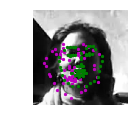

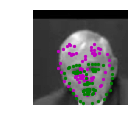

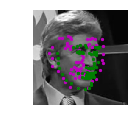

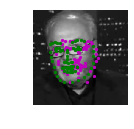

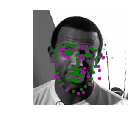

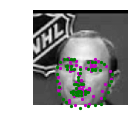

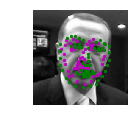

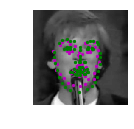

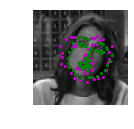

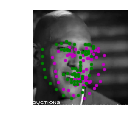

In [25]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [0]:
## TODO: change the name to something uniqe for each new model
model_dir = '/content/drive/My Drive/P1_Facial_Keypoints-master/saved_models'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Loss Function used:  is Mean Squared Error Loss (MSE_Loss) for regression as the problem require continuous or real values not discrete.

Optimizer Used : is Stochiastic Gradient Descent(SGDOptimizer ) for descending toward final wieghts fast as possible, As training instances are in thousands. And in long run time taken by SGD is comparatively low, and results on  test instance is good .

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: **Initial Architecture**

 Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Dropped this archetecture Because Architecture is quite heavy for the task as in last layer depth is 32 that is 32 wieght matrix Therefore model was taking too long to train and infer.

**In** between, I tried many different architectures tweaked hyperparameters for whole day and night. At last I get to this final architecture which worked just fine with GPU support.



**Final Architecture**


Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


This architecture worked because depth in convolving layers are 3 and 9 which is far less then 32 and seem to capture all the relevant wieght matrix as filters which in response is fast and in 50th epoch Average loss decreased to **Avg. Loss: 0.0010922687202692032** and trained network work pretty well on test data.


**Yeah**, for this final architecture I dropped layers and also tuned hyper-parameters i.e epochs,batch_size, depth(no. of filters) to avoid overfitting.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: It was simple in this case, I just followed Average training loss to minimum possible with increasing number of epochs. And checked for over-fitting by checking result of facial landmarks on test images comparative to idol or given facial landmarks.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.04295286 -0.11549288  0.00184732 -0.00871773  0.09544803]
 [-0.05294241 -0.12678091  0.03625398  0.06043987 -0.11596397]
 [-0.11847709  0.1874966  -0.1415935  -0.17334446 -0.01228555]
 [ 0.0143793   0.12594406  0.16696809 -0.10548301 -0.03947644]
 [ 0.20186317  0.2084457  -0.01496045 -0.0922098  -0.03371769]]
(5, 5)


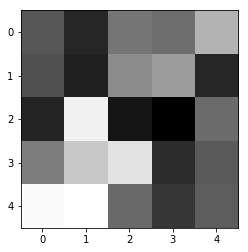

In [48]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)
filter = w[filter_index][0]
# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

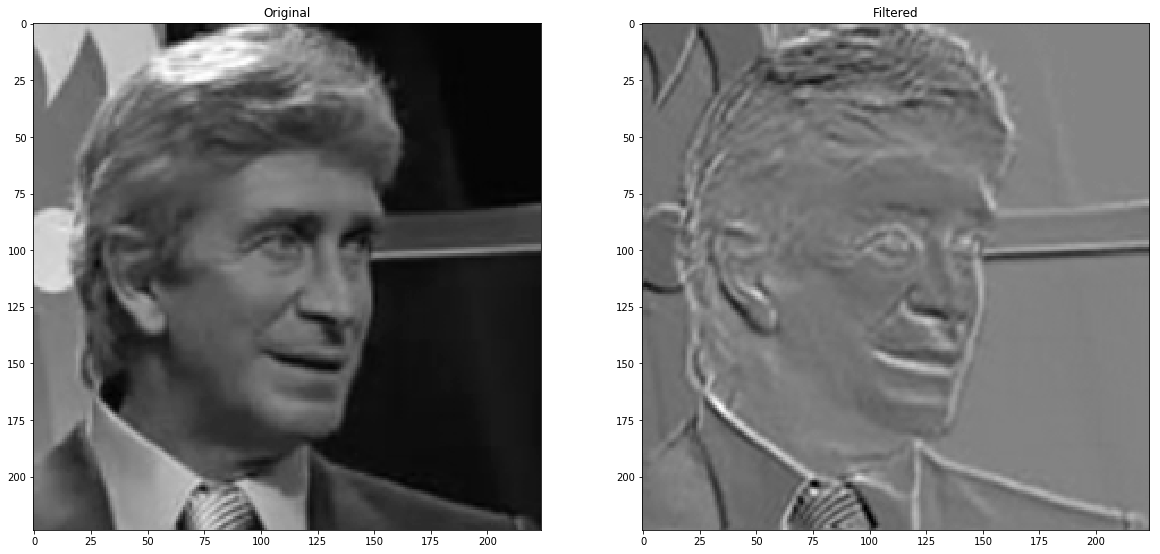

In [57]:
##TODO: load in and display any image from the transformed test dataset
imag =np.squeeze(test_images[2])
#plt.imshow(imag,cmap = 'gray')
ima = imag.numpy()

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered_image = cv2.filter2D(ima, -1, filter)
#plt.imshow(filtered_image,cmap = 'gray')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Original')
ax1.imshow(imag, cmap='gray')

ax2.set_title('Filtered')
ax2.imshow(filtered_image, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: This filter detects horizontal edges and looks like it doesn't blur image as facial stucture defining thin lines are still visible.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!